In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

from traffic.core import Traffic
from traffic.data import airports
from traffic.data import navaids

In [2]:
t_ga = Traffic.from_file("../deep_traffic_generation/data/data_lszh/ga14_proc_reduced.pkl") 
t_to = Traffic.from_file("../deep_traffic_generation/data/data_lszh/to_16_cleaned_reduced.pkl")

# Test

Pour détecter les mauvais tracks: 
- On fait la différence (t+1) - t
- On regarde quand cette différence est trop grande mais pas trop (supérieure à 30, mais inférieure à 330. Ca veut dire qu'on interpole dans le sens horaire au lieu de l'anti-horaire)
- On regarde les n id correspondants
- Les mauvais tracks sont de id[0] à id[n-1]

Pour refaire l'interpolation:
- on fait +360 uniquement sur les valeurs vers le nord est (0-10 etc)
- On interpole entre les valeurs autours des 350 avec les valeurs autour des 10
- on fait -360 uniquement sur les valeurs > 360

# Modify spurious track values

In [60]:
# #Testing

# bad_track = {}

# for f in tqdm(t_ga):
#     dif = f.data.track.diff(1)
#     mask = (dif > 30) & (dif < 330)
#     id = mask[mask].index
    
#     #Celui-ci n'est pas bon du tout: analyser pourquoi
#     if f.flight_id == "AFL2486_18467":
#         print(len(xvals))
    
#     if mask.sum() > 0:
#         bad_track[f.flight_id] = f.data.track.loc[(id.min()-1):id.max()]
        
#         #Values that we know they are true
#         xp = [f.data.timestamp.loc[id.min()-1].value, f.data.timestamp.loc[id.max()].value]
#         fp = [f.data.track.loc[id.min()-1] + 360, f.data.track.loc[id.max()]]
        
#         #interpolate new values
#         xvals = f.data.timestamp.loc[id.min():(id.max()-1)].apply(lambda x: x.value).tolist()
        
#         interp = np.interp(xvals, xp, fp).tolist()
#         interp = [x if x < 360 else x-360 for x in interp]
#         f.data.loc[id.min():(id.max()-1), "track"] = interp

 16%|█▌        | 110/703 [00:00<00:00, 618.83it/s]

4


100%|██████████| 703/703 [00:00<00:00, 863.90it/s]


In [67]:
# Marche très bien pour résoudre le problème du passage de 0 à 360 dans le sens anti-horaire
# Néanmoins, certain flight ont des track erronés de base

from traffic.core import Flight

def reinterpolate_track(f):
        dif = f.data.track.diff(1)
        mask = (dif > 30) & (dif < 330)
        id = mask[mask].index
        
        if mask.sum() > 0:
            #Values that we know they are true
            xp = [f.data.timestamp.loc[id.min()-1].value, f.data.timestamp.loc[id.max()].value]
            fp = [f.data.track.loc[id.min()-1] + 360, f.data.track.loc[id.max()]]
            
            #interpolate new values
            xvals = f.data.timestamp.loc[id.min():(id.max()-1)].apply(lambda x: x.value).tolist()
            interp = np.interp(xvals, xp, fp).tolist()
            interp = [x if x < 360 else x-360 for x in interp]
            f.data.loc[id.min():(id.max()-1), "track"] = interp
            
        return Flight(f.data)

In [68]:
new_ga = t_ga.iterate_lazy().pipe(reinterpolate_track).eval(desc = "")
new_to = t_to.iterate_lazy().pipe(reinterpolate_track).eval(desc = "")

  83% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━ 7,081/8,552  [ 0:00:04 < 0:00:01 , 1,719 it/s ]
  83% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━ 7,081/8,552  [ 0:00:04 < 0:00:01 , 1,719 it/s ]

# Computation of Track based on lat/lon

- Project into x/y
- track = angle w.r.t the geometric North
- Take segments between points, enad compute angle. 

In [208]:
from math import atan2,pi
import pyproj
from traffic.core import Flight
swissGrid = pyproj.Proj(init="EPSG:21781")

def angle(x,y):
    return atan2(x,y)*180/pi

def compute_track(f):
    diff_x = (-f.data.x.diff(-1)).tolist() # at obs n, we compute x(n+1) - x(n)
    diff_y = (-f.data.y.diff(-1)).tolist()
    f.data["computed_track"] = list(map(angle, diff_x, diff_y))
    # f.data.loc[f.data['track'] > 180, 'track'] = f.data.loc[f.data['track'] > 180, 'track'] - 360
    f.data.loc[f.data['computed_track'] < 0, 'computed_track'] = f.data.loc[f.data['computed_track'] < 0, 'computed_track'] + 360
    return Flight(f.data)

test_ga = new_ga.compute_xy(swissGrid).iterate_lazy().pipe(compute_track).unwrap(["track", "computed_track"]).eval(desc = "")
# test_to = new_to.compute_xy(swissGrid).iterate_lazy().pipe(compute_track).unwrap(["track", "computed_track"]).eval(desc = "")
test_to = t_to.compute_xy(swissGrid).iterate_lazy().pipe(compute_track).unwrap(["track", "computed_track"]).eval(desc = "")

  99% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 8,503/8,552  [ 0:00:27 < 0:00:01 , 311 it/s ]
  99% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 8,503/8,552  [ 0:00:27 < 0:00:01 , 311 it/s ]

# Comparison between true traj and reconstructed traj from track

Two comparisons :
- reconstruction between track and computed_track
- recontruction with track and and withoriginal lat/lon

Pourquoi en reconstruisant la trajectoire y a t il un offset ?

In [29]:
test_ga = Traffic.from_file("../deep_traffic_generation/data/training_datasets/ga_LSZH_14.pkl") 
# test_to = Traffic.from_file("../deep_traffic_generation/data/training_datasets/to_LSZH_16.pkl")
test_to = Traffic.from_file("../deep_traffic_generation/data/data_lszh/to_16_cleaned.pkl")

In [45]:
t_to = Traffic.from_file("../deep_traffic_generation/data/data_lszh/LSZH_takeoffs.parquet.gz")

def takeoff_16(f):
    candidate = f.takeoff_from_runway("LSZH").next()
    if candidate is not None:
        if candidate.max("runway") == '16':
            return f
        else:
            return None

test_to = t_to.iterate_lazy().pipe(takeoff_16).eval(desc = "", max_workers = 50)

 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 99,004/99,006  [ 0:15:16 < 0:00:01 , 112 it/s ]
 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 99,004/99,006  [ 0:15:16 < 0:00:01 , 112 it/s ]

In [46]:
test_to[0].data.track.tolist()

[156.0774941169867,
 156.2361779806719,
 156.1940564815423,
 156.1940564815423,
 156.153182024761,
 155.2771604476895,
 155.4328286793987,
 154.7406094801911,
 154.5677685812895,
 154.3715811217825,
 154.3715811217825,
 154.2091689878501,
 153.434948822922,
 152.81888891452283,
 150.2125828686205,
 145.9311229224114,
 141.7661748225531,
 138.3664606634298,
 135.4814658058384,
 132.82525588539,
 128.9784098609567,
 125.7760777178946,
 122.36663806472498,
 119.15378884624418,
 116.56505117707802,
 113.5121686622856,
 110.275578608991,
 106.927513064147,
 104.4490301264595,
 101.3099324740202,
 98.5645186425756,
 95.13255443987296,
 92.04540848888723,
 88.97696981133217,
 86.25383795039637,
 84.18751761688728,
 83.17075569680195,
 81.48601207024966,
 79.42202953243273,
 74.98163936884933,
 70.07441934181567,
 64.03331641021936,
 57.14427804956701,
 51.65442504600659,
 44.52649194126507,
 40.02000040368902,
 34.52576517177418,
 27.46256177363711,
 334.60707744385707,
 334.60707744385707,
 

In [47]:
def compute_latlon_from_trackgs(
    data: pd.DataFrame,
    n_samples: int,
    n_obs: int,
    coordinates,
    forward: bool = True,
) -> pd.DataFrame:

    from traffic.core.geodesy import destination

    df = data.copy(deep=True)
    if not forward:
        df["track"] = df["track"].values[::-1] - 180
        df["groundspeed"] = df["groundspeed"].values[::-1]
        df["timestamp"] = df["timestamp"].values[::-1]
    lat = np.array(
        ([coordinates["latitude"]] + [np.nan] * (n_obs - 1)) * n_samples
    )
    lon = np.array(
        ([coordinates["longitude"]] + [np.nan] * (n_obs - 1)) * n_samples
    )

    for i in range(len(df)):
        if np.isnan(lat[i]) or np.isnan(lon[i]):
            lon1 = lon[i - 1]
            lat1 = lat[i - 1]
            track = df.loc[i - 1, "track"]
            gs = df.loc[i - 1, "groundspeed"]
            delta_time = abs(
                (
                    df.loc[i, "timestamp"] - df.loc[i - 1, "timestamp"]
                ).total_seconds()
            )
            coeff = 0.99
            # coeff = 1
            d = coeff * gs * delta_time * (1852 / 3600)
            lat2, lon2, _ = destination(lat1, lon1, track, d)
            lat[i] = lat2
            lon[i] = lon2

    if not forward:
        lat, lon = lat[::-1], lon[::-1]

    return data.assign(latitude=lat, longitude=lon)

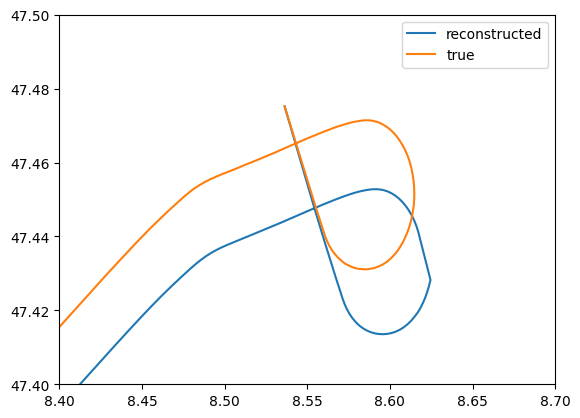

In [50]:
# from traffic.algorithms.generation import compute_latlon_from_trackgs

# i = np.random.randint(len(new_ga))
i = np.random.randint(len(test_to))
# i = 'THY3YJ_111077'

df_track = test_to[i].data[["flight_id", "timestamp", "track", "groundspeed"]].reset_index()
# df_computed_track = test_ga[i].data[["flight_id", "timestamp", "computed_track", "groundspeed"]]

coordinates = dict(latitude = test_to[i].data.iloc[0]["latitude"], longitude = test_to[i].data.iloc[0]["longitude"])

reco_track = compute_latlon_from_trackgs(df_track, 1, df_track.shape[0], coordinates, forward=True)
# reco_computed_track = compute_latlon_from_trackgs(df_track, 1, df_computed_track.shape[0], coordinates, forward=True)

#The main problem is when there are some missing points. Track is falsely interpolated
plt.plot(reco_track.longitude, reco_track.latitude, label = "reconstructed")
plt.plot(test_to[i].data.longitude, test_to[i].data.latitude, label = "true")
plt.xlim(8.4, 8.7)
plt.ylim(47.4, 47.5)
plt.legend()

In [74]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

mse = dict(flight_id = [], mse = [])
latlon = {}

for f in tqdm(test_ga):
    df_track = f.data[["flight_id", "timestamp", "track", "groundspeed"]]
    coordinates = dict(latitude = f.data.iloc[0]["latitude"], longitude = f.data.iloc[0]["longitude"])
    reco_track = compute_latlon_from_trackgs(df_track, 1, df_track.shape[0], coordinates, forward=True) 
    
    X1 = MinMaxScaler().fit_transform(reco_track[["longitude", "latitude"]])
    X1 = X1.ravel()

    X2 = MinMaxScaler().fit_transform(f.data[["longitude", "latitude"]])
    X2 = X2.ravel()
    
    mse["flight_id"].append(f.flight_id)
    if np.isnan(X1).any() or np.isnan(X2).any():
        mse["mse"].append(np.nan)
    else:
        mse["mse"].append(mean_squared_error(X1, X2))
        latlon[f.flight_id] = [f.data.latitude.values.tolist(), f.data.longitude.values.tolist(), reco_track.latitude.values.tolist(), reco_track.longitude.values.tolist()]
        
    
mse = pd.DataFrame(mse)

100%|██████████| 703/703 [00:22<00:00, 31.43it/s]


In [170]:
sus = mse[(mse.mse > mse.mse.quantile(0.975))].flight_id.values
len(sus)

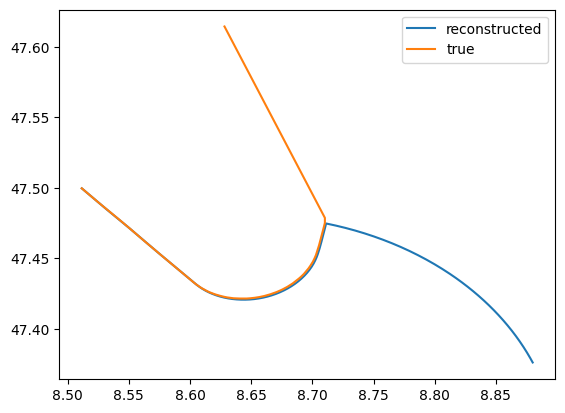

In [184]:
r = np.random.choice(sus)
latlon[r]
plt.plot(latlon[r][3], latlon[r][2], label = "reconstructed")
plt.plot(latlon[r][1], latlon[r][0], label = "true")
plt.legend()

In [190]:
t = test_ga.query(f"flight_id not in {sus.tolist()}")
t.to_pickle("../deep_traffic_generation/data/data_lszh/ga14_proc_reduced_track_cleaned.pkl")

In [232]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

mse = dict(flight_id = [], mse = [])
latlon = {}

for f in tqdm(test_to):
    df_track = f.data[["flight_id", "timestamp", "track", "groundspeed"]]
    coordinates = dict(latitude = f.data.iloc[0]["latitude"], longitude = f.data.iloc[0]["longitude"])
    reco_track = compute_latlon_from_trackgs(df_track, 1, df_track.shape[0], coordinates, forward=True) 
    
    X1 = MinMaxScaler().fit_transform(reco_track[["longitude", "latitude"]])
    X1 = X1.ravel()

    X2 = MinMaxScaler().fit_transform(f.data[["longitude", "latitude"]])
    X2 = X2.ravel()
    
    mse["flight_id"].append(f.flight_id)
    if np.isnan(X1).any() or np.isnan(X2).any():
        mse["mse"].append(np.nan)
    else:
        mse["mse"].append(mean_squared_error(X1, X2))
        latlon[f.flight_id] = [f.data.latitude.values.tolist(), f.data.longitude.values.tolist(), reco_track.latitude.values.tolist(), reco_track.longitude.values.tolist()]
        
    
mse = pd.DataFrame(mse)

100%|██████████| 8552/8552 [03:05<00:00, 46.08it/s]


In [247]:
sus = mse[(mse.mse > mse.mse.quantile(0.95))].flight_id.values
len(sus)

428

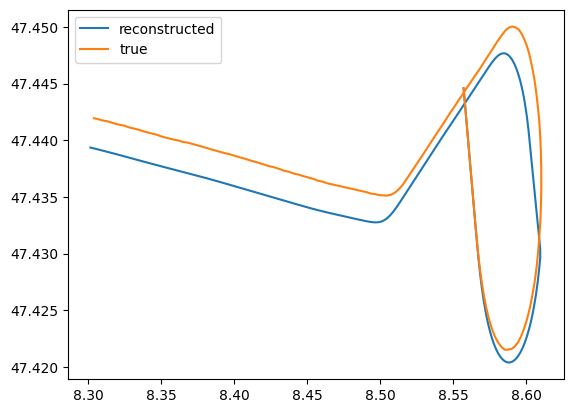

In [269]:
r = np.random.choice(sus)
latlon[r]
plt.plot(latlon[r][3], latlon[r][2], label = "reconstructed")
plt.plot(latlon[r][1], latlon[r][0], label = "true")
plt.legend()

In [270]:
t = test_to.query(f"flight_id not in {sus.tolist()}")
t.to_pickle("../deep_traffic_generation/data/data_lszh/to_16_cleaned_reduced_track_cleaned.pkl")